# Initial Work for Test Network


## Notebook Setup

<div hidden>
$\usepackage{cancel}$
$\usepackage{amssymb}$
</div>

In [1]:
# Required packages
#!pip install torch torchvision pandas numpy matplotlib scipy plotly tensorboard onnx

In [2]:
# Visualize tensorboard in the notebook
%load_ext tensorboard
# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

In [3]:
from models.simpleFork import Simple, Fork
from models.danmf import DANMF
from models.convmf import ConvMF
from datasets.yt_vidframes import YtVidsDataset
from framework.saveload import load_checkpoint, load_trained_model

import os
from collections import namedtuple
from timeit import default_timer
import re
from datetime import datetime
import json

import torch
import onnx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, diagsvd
from torch import nn
from torch.utils.data import DataLoader, random_split
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import profiler

### Per-run user defined variables

In [4]:
# Define the machine being used
# machine = "Macbook"
machine = "PC"

## FORMAT: {machine}, {model}, {datetime}
state_dict_str = "{}_{}_state-dict_{}.pt"
checkpoint_dict_str = "{}_{}_checkpoint_{}.tar"

Checkpoint = namedtuple("Checkpoint", ["model", "epoch", "loss", "validation_loss", "opt_state_dict", "train_time"])
# data_dir = os.path.join("..", "data")
# output_dir = os.path.join(data_dir, "output")
data_dir = os.path.join("../../", "data")
output_dir = os.path.join(data_dir, "output")
tensorboard_dir = os.path.join(output_dir, "tensorboard")



## Data 

We remove the channels in the images (convert to grayscale) to more closely mimic the actual plasma dataset

* [Helpful Link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


#### Normalization
* Normalize each image with respect to its unit Frobenius norm

### Dataset

In [5]:
# Dataset params
batch_size = 25
img_size = [54, 96]
imgs_dir = os.path.join(data_dir, "images_96x54")

# Load and split the data, and prep for being fed into the NN
data = YtVidsDataset(imgs_dir)
# Divide data into train, validation, test
train_data, validation_data, test_data = random_split(data, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

6741 <class 'torch.Tensor'> torch.Size([54, 96])
tensor([[0.0160, 0.0155, 0.0152,  ..., 0.0163, 0.0162, 0.0162],
        [0.0156, 0.0158, 0.0155,  ..., 0.0160, 0.0159, 0.0158],
        [0.0148, 0.0154, 0.0150,  ..., 0.0158, 0.0157, 0.0156],
        ...,
        [0.0147, 0.0146, 0.0145,  ..., 0.0140, 0.0136, 0.0141],
        [0.0147, 0.0146, 0.0145,  ..., 0.0140, 0.0136, 0.0141],
        [0.0146, 0.0146, 0.0145,  ..., 0.0140, 0.0136, 0.0142]])


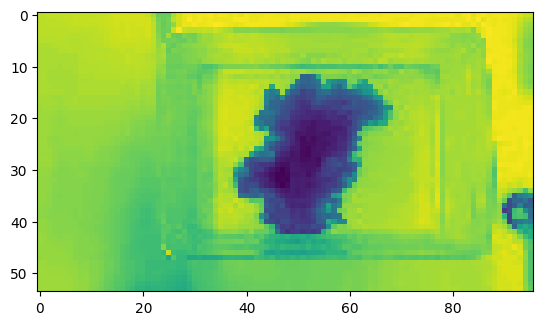

In [6]:
plt.imshow(data[2669])
print(len(data), type(data[0]), data[244].shape)
print(data[2000])

## Hyperparameters


### Structure

#### DANMF Implementation from papers

* **Non-alternating/nonnegative Matrix Factorization (NMF)**: Classical deep NMF for a non-negative matrix X ∈ Rm×n + can be described as follows: first, X is decomposed as X ≈ U0V 0 where U 0 ∈ Rm×r0 +  and V 0 ∈ Rr0×n + . The coding matrix V 0 is then further decomposed as V 0 ≈ U 1V 1 where U 1 ∈ Rr0×r1 +  and V 1 ∈ Rr1×n +. The procedure is repeated until a pre-fixed number of layers is reached. [[2]](#r2)
* **deep alternating non-negative matrix factorisation (DA-NMF)**: we propose to factorise the basis and coding matrices in an alternating order along the layers. [[2]](#r2)
    * Uses approx 6-8 layers

<img src="images/r2_fig1.png" alt="Drawing" style="width: 400px;"/>
<!-- ![image.png](images/r2_fig1.png) -->


### L-System
* Using L (Lindenmayer) Systems to define strucure?
* Node types:
    * Terminating (1 -> 0)
    * Splitting (1 -> 2)
    * Unifying (2 ->1)
    * Direct (1 -> 1)
    * Starting (0 -> 1)


### Loss Function
We use methods defined in [[1]](#r1) to define our loss function <!-- $\mathcal{L}$ \\ -->

$$
\min_{\substack{U \in \real^{m\times r} \\ V \in \real^{r\times n}}} ||X - ReLU(UV)||^2_F ,
$$
Where we are finding the square Frobenius norm of the difference between the original matrix $X$ and the rectified linear low rank representation matrices $UV$

#### From paper

Eq. 10-11 [[2]](#r2)



### Optimizer

Adam works fine / is standard



## Model Definition

### General params

In [7]:
# Select device to use for compute power
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
use_cuda = device == "cuda"

Using cuda device


### Various Models

In [8]:
# layer_dims = (500, 400, 300, 200, 100, 100)

model_fork = Fork().to(device)
print(model_fork)
print(model_fork.get_name(), model_fork.get_hyperparameters())



Fork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (seq): Sequential(
    (0): Sequential(
      (0): Linear(in_features=5184, out_features=500, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=400, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=400, out_features=300, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=300, out_features=200, bias=True)
      (1): Tanh()
    )
  )
  (U): Sequential(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=300, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=300, out_features=200, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (4): Sequential(
      (0):

In [9]:
model_danmf = DANMF().to(device)
print(model_danmf)

# writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model_danmf.get_name()}_{runname}'))
# writer.add_graph(model_danmf, next(iter(train_dataloader)).to(device))
# writer.flush()

DANMF(
  (input): Flatten(start_dim=1, end_dim=-1)
  (U): ModuleDict(
    (0): Sequential(
      (0): Linear(in_features=5184, out_features=8100, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(54, 150))
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=15000, out_features=10500, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(150, 70))
      (2): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=3500, out_features=2100, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(70, 30))
      (2): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=1500, out_features=300, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(30, 10))
    )
  )
  (V): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=14400, out_features=9600, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(100, 96))
      (2): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=7000, out_features=5000, bias=True)
   

In [10]:
model_conv = ConvMF().to(device)
print(model_conv)

ConvMF(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (seq): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4888, out_features=500, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=200, bias=True)
      (1): Tanh()
    )
  )
  (U): Sequential(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=300, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=300, out_features=324, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(54, 6))
    )
  )
  (V): Sequential(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=300, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=300, out_features=576, bias=

## Running the model

### Training

In [13]:
def loss_fcn(X, U, V):
    return torch.mean(
            torch.square(
                torch.linalg.matrix_norm(X - nn.functional.relu(torch.bmm(U, V)),
                # Don't enforce non-negativity on UV?
                # torch.linalg.matrix_norm(X - torch.bmm(U, V),
                                         ord='fro')))

# loop over the dataset multiple times
def train_model(model, optimizer, output_run_dir, epochs=15, checkpoint_at = -1, load = True, batch_pr = 200, writer=None, profiler=None, **kwargs):
    mname = model.get_name()
    start_epoch = -1

    print(f"Training {mname}")

    # Attempt to load the previous checkpoint
    if load:
        checkpoint, statedict = load_checkpoint(mname, machine, output_run_dir)
        if checkpoint and statedict:
            start_epoch = checkpoint["epoch"]
            optimizer.load_state_dict(checkpoint["opt_state_dict"])
            model.load_state_dict(statedict)
        else:
            print("No checkpoint found to load. Using base model")


    # Save basic hyperparams
    if writer:
        writer.add_hparams(model.get_hyperparameters(True), {})
        writer.flush()

    loss_arr = []
    validation_arr = []
    time_arr = []
    for e in range(start_epoch+1, start_epoch+1 + epochs ):
        model.train()
        running_loss = 0.0
        running_time = 0.0

        for i, data in enumerate(train_dataloader, 0):
            data = data.to(device)

            # Write out a view of the NN graph, just once
            if writer and e == 0 and i == 0:
                writer.add_graph(model, data)
                writer.flush()
                torch.onnx.export(model, data, os.path.join(output_run_dir, f'{mname}_model.onnx'), input_names=["matrix"], output_names=["V", "U"])

            start_time = default_timer()
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            U, V = model(data)
            # Loss function
            loss = loss_fcn(data, U, V)
            loss.backward()
            optimizer.step()
            running_time = default_timer() - start_time

            running_loss += loss.item()
            # Print and save statistics
            if i % batch_pr == batch_pr - 1:    # print every 200 mini-batches
                avg_loss = running_loss / batch_pr
                loss_arr.append(avg_loss)
                avg_time = running_time / batch_pr
                time_arr.append(avg_time)

                # Determine validation loss
                model.eval()
                model.train(False)
                v_arr = []
                for v_data in validation_dataloader:
                    v_data = v_data.to(device)
                    U_v, V_v = model(v_data)
                    v_arr.append(loss_fcn(v_data, U_v, V_v).item())
                validation_arr.append(np.mean(v_arr))
                model.train(True)

                # Write out stats
                print(f"[{e}, {i+1}] loss: {avg_loss}, validation loss: {validation_arr[-1]}, average train time (sec): {avg_time}")
                if writer:
                    writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : validation_arr[-1] },
                            e * len(train_dataloader) + i)
                    writer.add_scalar('Average Train Time (s)', avg_time, e * len(train_dataloader) + i)
                    writer.flush()

                running_loss = 0.0
                running_time = 0.0

            if profiler:
                profiler.step()

        # Save output to checkpoint dict
        if e % checkpoint_at == checkpoint_at - 1:
            dt = datetime.now().strftime('%Y-%m-%d_%H%M%S')
            save = Checkpoint(mname, e, loss_arr, validation_arr, optimizer.state_dict(), time_arr)._asdict()
            torch.save(save, os.path.join(output_run_dir, checkpoint_dict_str.format(machine, mname, dt)))
            torch.save(model.state_dict(), os.path.join(output_run_dir, state_dict_str.format(machine, mname, dt)))
            print(f"Saved checkpoint for epoch {e}: {machine}_{mname}")
            loss_arr = []
            validation_arr = []
            time_arr = []

    # Always save output at end
    dt = datetime.now().strftime('%Y-%m-%d_%H%M%S')
    save = Checkpoint(mname, e, loss_arr, validation_arr, optimizer.state_dict(), time_arr)._asdict()
    torch.save(save, os.path.join(output_run_dir, checkpoint_dict_str.format(machine, mname, dt)))
    torch.save(model.state_dict(), os.path.join(output_run_dir, state_dict_str.format(machine, mname, dt)))
    print(f"Saved checkpoint for epoch {e}: {machine}_{mname}")

    print('Finished Training')


##  torch.nn.functional.pad(input, pad, mode='constant', value=None) → Tensor

def trace_handler(prof):
    table = prof.key_averages().table(sort_by="self_cuda_time_total" if use_cuda else "self_cpu_time_total", row_limit=10)
    print(table)
    # ff = prof.key_averages()
    # df_table = pd.DataFrame(ff)
    # print(df_table)
    # df_table.to_csv("tst.csv")

    ## TODO: save to file, and tensorboard

### Multiple model running (various hyperparams)

In [14]:
## Params
ranks = [4, 5, 6, 7, 8, 9, 10, 11, 12]

stem_layer_dims = [500, 200]

fork_layer_dims = [200, 300]

conv_dims = [[5, 1, 3, 1], [3, 1, 0, 1]]


# Save details
run_details = {}
run_details["run_params"] = dict(epochs=120,
                                 checkpoint_at=40,
                                 batch_pr=40,
                                 batch_size=batch_size,
                                 subname="Winner1_ranks"
                                )
runname = run_details["run_params"]["subname"]
output_run_dir = os.path.join(output_dir, f"run_{runname}")

models = []

for r in ranks:
    m = Fork(r, img_size, stem_layer_dims, fork_layer_dims).to(device)
    print(f"{m.get_name()} \trank = {r} \t sl={stem_layer_dims} \t fl={fork_layer_dims} \tcl={0}")
    models.append(m)
    run_details[m.get_name()] = m.get_hyperparameters()

    m = ConvMF(r, img_size, stem_layer_dims, fork_layer_dims, conv_dims).to(device)
    print(f"{m.get_name()} \trank = {r} \t sl={stem_layer_dims} \t fl={fork_layer_dims} \tcl={conv_dims}")
    models.append(m)
    run_details[m.get_name()] = m.get_hyperparameters()

# m = Fork(nn_rank, img_size, stem_layer_dims[0], fork_layer_dims[0]).to(device)
# print(f"{m.get_name()} \trank = {nn_rank}, \tcl={0} \t sl={stem_layer_dims[0]}, \t fl={fork_layer_dims[0]}")
# models.append(m)
# run_details[m.get_name()] = m.get_hyperparameters()
# for i, cl in enumerate(conv_dims):
#     if i == 0:
#         for sl in stem_layer_dims:
#             for fl in fork_layer_dims:
#                 m = ConvMF(nn_rank, img_size, sl, fl, cl).to(device)
#                 print(f"{m.get_name()} \trank = {nn_rank}, \tcl={cl} \t sl={sl}, \t fl={fl}")
#                 models.append(m)
#                 run_details[m.get_name()] = m.get_hyperparameters()
#     else:
#         m = ConvMF(nn_rank, img_size, stem_layer_dims[0], fork_layer_dims[0], cl).to(device)
#         print(f"{m.get_name()} \trank = {nn_rank}, \tcl={cl} \t sl={stem_layer_dims[0]}, \t fl={fork_layer_dims[0]}")
#         models.append(m)
#         run_details[m.get_name()] = m.get_hyperparameters()


Fork_r4_sdim2-3ebc_fdim2-37e7 	rank = 4 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_r4_cdim2-c00f 	rank = 4 	 sl=[500, 200] 	 fl=[200, 300] 	cl=[[5, 1, 3, 1], [3, 1, 0, 1]]
Fork_r5_sdim2-3ebc_fdim2-37e7 	rank = 5 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_r5_cdim2-c00f 	rank = 5 	 sl=[500, 200] 	 fl=[200, 300] 	cl=[[5, 1, 3, 1], [3, 1, 0, 1]]
Fork_sdim2-3ebc_fdim2-37e7 	rank = 6 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_cdim2-c00f 	rank = 6 	 sl=[500, 200] 	 fl=[200, 300] 	cl=[[5, 1, 3, 1], [3, 1, 0, 1]]
Fork_r7_sdim2-3ebc_fdim2-37e7 	rank = 7 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_r7_cdim2-c00f 	rank = 7 	 sl=[500, 200] 	 fl=[200, 300] 	cl=[[5, 1, 3, 1], [3, 1, 0, 1]]
Fork_r8_sdim2-3ebc_fdim2-37e7 	rank = 8 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_r8_cdim2-c00f 	rank = 8 	 sl=[500, 200] 	 fl=[200, 300] 	cl=[[5, 1, 3, 1], [3, 1, 0, 1]]
Fork_r9_sdim2-3ebc_fdim2-37e7 	rank = 9 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_r9_cdim2-c00f 	rank = 9 	 sl=[500, 200] 	 fl=[200, 

In [15]:
run_details

{'run_params': {'epochs': 120,
  'checkpoint_at': 40,
  'batch_pr': 40,
  'batch_size': 25,
  'subname': 'Winner1_ranks'},
 'Fork_r4_sdim2-3ebc_fdim2-37e7': {'stem_layer_dims': [500, 200],
  'fork_layer_dims': [200, 300],
  'rank': 4,
  'img_size': [54, 96],
  'desc': 'Linear layers that fork into two separate channels for U, V'},
 'ConvMF_r4_cdim2-c00f': {'conv_dims': [[5, 1, 3, 1], [3, 1, 0, 1]],
  'stem_layer_dims': [500, 200],
  'fork_layer_dims': [200, 300],
  'rank': 4,
  'img_size': [54, 96],
  'desc': 'Conv layer(s) into Fork model'},
 'Fork_r5_sdim2-3ebc_fdim2-37e7': {'stem_layer_dims': [500, 200],
  'fork_layer_dims': [200, 300],
  'rank': 5,
  'img_size': [54, 96],
  'desc': 'Linear layers that fork into two separate channels for U, V'},
 'ConvMF_r5_cdim2-c00f': {'conv_dims': [[5, 1, 3, 1], [3, 1, 0, 1]],
  'stem_layer_dims': [500, 200],
  'fork_layer_dims': [200, 300],
  'rank': 5,
  'img_size': [54, 96],
  'desc': 'Conv layer(s) into Fork model'},
 'Fork_sdim2-3ebc_fdim2-3

### Run models

In [16]:
if not os.path.exists(output_run_dir):
    os.mkdir(output_run_dir)

# Save details
with open(os.path.join(output_run_dir, f"details_{runname}.json"), "w" ) as write:
    json.dump(run_details, write, indent=2 )


for model in models:
# for model in models[-1:]:
    writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model.get_name()}_{runname}'))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    train_model(model, optimizer, output_run_dir, **run_details["run_params"], writer=writer, load=True)
    writer.close()

Training ConvMF_r12_cdim2-c00f
Found checkpoint to load. Using: PC_ConvMF_r12_cdim2-c00f_checkpoint_2023-11-27_032136.tar
Found model state dict to load. Using: PC_ConvMF_r12_cdim2-c00f_state-dict_2023-11-27_032136.pt
[80, 40] loss: 0.005513838154729456, validation loss: 0.005583635891594415, average train time (sec): 0.0001989050000005932
[80, 80] loss: 0.005673635780112818, validation loss: 0.005567064157353257, average train time (sec): 5.328750000046512e-05
[80, 120] loss: 0.006264014943735674, validation loss: 0.007470091444633479, average train time (sec): 5.661000000003469e-05
[80, 160] loss: 0.00872987158363685, validation loss: 0.006559977114622323, average train time (sec): 5.2627499999857716e-05
[81, 40] loss: 0.006696912960615009, validation loss: 0.007073415188505402, average train time (sec): 4.710999999986143e-05
[81, 80] loss: 0.006672021996928379, validation loss: 0.005752058379035795, average train time (sec): 4.2834999999286086e-05
[81, 120] loss: 0.00577710364013910

### Single model running

In [14]:
# model = Fork(nn_rank, img_size, [500, 200], [200, 300]).to(device)
model = model_danmf
runname = "Better_opt"
output_run_dir = output_dir
writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model.get_name()}_{runname}'))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


train_model(model, optimizer, output_run_dir, epochs=120, checkpoint_at=30, batch_pr=40, writer=writer, load=False)

# with profiler.profile(activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA] if use_cuda else [profiler.ProfilerActivity.CPU],
#                          record_shapes=False,
#                          profile_memory=True,
#                          # use_cuda=use_cuda,
#                          schedule=torch.profiler.schedule(
#                             wait=1,
#                             warmup=1,
#                             active=2,
#                             repeat=1),
#                          on_trace_ready=trace_handler
#                          ) as prof:
#         with profiler.record_function("train_model"):
#             train_model(15, model, optimizer, checkpoint_at=5, writer=writer, load=False, profiler=prof)






Training DANMF
[0, 40] loss: 0.9970015108585357, validation loss: 0.9977373278365945, average train time (sec): 8.640750000381559e-05
[0, 80] loss: 0.9970015019178391, validation loss: 0.9977372952227322, average train time (sec): 8.593250000217267e-05
[0, 120] loss: 0.9960014522075653, validation loss: 0.9977373075935075, average train time (sec): 9.168500000100721e-05
[0, 160] loss: 0.9970014408230782, validation loss: 0.9984920373502767, average train time (sec): 8.531999999945583e-05
[1, 40] loss: 0.9960015803575516, validation loss: 0.9977373053442757, average train time (sec): 8.184499999970285e-05
[1, 80] loss: 0.9970013990998268, validation loss: 0.9977373098427395, average train time (sec): 9.473500000467538e-05
[1, 120] loss: 0.9970014497637749, validation loss: 0.9977373030950438, average train time (sec): 8.481999999503387e-05
[1, 160] loss: 0.9980013832449913, validation loss: 0.9977372974719642, average train time (sec): 8.727500000986766e-05
[2, 40] loss: 0.9970014646649

KeyboardInterrupt: 

#### Winners

* Mac_Fork_sdim2-3ebc_fdim2-37e7_Conv_1
* Mac_ConvMF_cdim2-c00f_Conv_1
* Mac_ConvMF_cdim2-2d8c_Conv_1
* Mac_ConvMF_cdim2-f2cd_Conv_1

### Setup to load and run against SVD

In [ ]:
## Params
runname = "Conv_1"
model_str_name = "ConvMF_cdim2-f2cd"

model = load_trained_model(ConvMF, "Mac", runname, model_str_name, output_run_dir)
print(model, model.get_name())

# writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model.get_name()}_{runname}'))

# def save_prof(prof):
#     prof_events = prof.key_averages()

# with profiler.profile(activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA] if use_cuda else [profiler.ProfilerActivity.CPU],
#                          record_shapes=False,
#                          profile_memory=True,
#                       on_trace_ready=save_prof
#                          ) as prof:
#     U, V = model(next(iter(validation_dataloader)))
#     prof.step()
#     prof_events = prof.key_averages()



## Comparision against base

Compare against some python implementation of SVD that produces U: m x r V: r x n matrices

In [ ]:
writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model.get_name()}_{runname}'))
# writer = SummaryWriter(os.path.join(tensorboard_dir, f'Mac_{model.get_name()}_{runname}_Winner'))

## Params
svd_rank = 5
step = 2 # For tensorboard, to set what "global step" the histograms occured at

losses_nn = []
losses_svd = []
times_nn = []
times_svd = []


# imgs = next(iter(validation_dataloader))

for img in test_dataloader:
    img = img.to(device)

    # Run and time the NN
    start_nn = default_timer()

    model.eval()
    U_nn, V_nn = model(img)
    U_nn = torch.squeeze(U_nn).cpu().detach().numpy()
    V_nn = torch.squeeze(V_nn).cpu().detach().numpy()
    UV_nn = np.maximum(np.matmul(U_nn, V_nn), 0)

    end_nn = default_timer() - start_nn
    times_nn.append(end_nn)

    img = torch.squeeze(img.to("cpu"))

    # Run and time standard SVD, truncating to rank
    svds = []
    start_svd = default_timer()

    U_svd, S, V_svd = svd(img)
    S = S[:svd_rank]
    U_svd = U_svd[:, :svd_rank]
    V_svd = V_svd[:svd_rank, :]
    svd_USV = U_svd.dot(diagsvd(S, svd_rank, svd_rank)).dot(V_svd)

    # for i in range(batch_size):
    #     U_svd, S, V_svd = svd(imgs[i, :, :])
    #     S = S[:svd_rank]
    #     U_svd = U_svd[:, :svd_rank]
    #     V_svd = V_svd[:svd_rank, :]
    #     svds.append(U_svd.dot(diagsvd(S, svd_rank, svd_rank)).dot(V_svd))

    end_svd = default_timer() - start_svd
    times_svd.append(end_svd)

    # Calculate loss
    loss_nn = np.square(np.linalg.norm(img - UV_nn, ord="fro"))
    loss_svd = np.square(np.linalg.norm(img - svd_USV, ord="fro"))
    losses_nn.append(loss_nn)
    losses_svd.append(loss_svd)

writer.add_histogram("Model avg loss", np.array(losses_nn), step)
writer.add_histogram("SVD avg loss", np.array(losses_svd), step)
writer.add_histogram("Model time", np.array(times_nn), step)
writer.add_histogram("SVD time", np.array(times_svd), step)
writer.flush()
writer.close()

print("SimpleNN:\n", "Loss (avg) =", np.mean(losses_nn), "\tTime =", np.mean(times_nn))
print("Scipy SVD:\n", "Loss (avg) =", np.mean(losses_svd), "\tTime =", np.mean(times_svd))


In [ ]:
U_svd, S, V_svd = svd(imgs[i, :, :])
# plt.semilogy(S)
plt.semilogy(np.sqrt(np.linalg.norm(S)**2 - np.cumsum(S**2)) / np.linalg.norm(S))

# TODO

* ~~Save hyperparameters, run params to dict (json?)~~
* ~~Run against bigger networks~~
* ~~Compare rank vs err (loss) for SVD vs NN, and see how many more ranks it is to get comparable err~~
    * ~~compare against SVD 4, using rank 6 for NN (or bigger)~~
    * <img src="images/rank_vs_err.png" alt="Rank vs Error Plot" style="width: 600px;"/>
* ~~Use a different algo where we pre-give the rank, better alg: `scipy.sparse.linalg.svds`, tol=0.001~~
* Impose nonneg on U, V BEFORE multiplying
* ~~Generate the data~~
    * ~~Make a movie of hte fs, to sanity check~~
* Try supervised learning with `torch.nn.KLDivLoss(reduction = "batchmean")`
    * Remember needs log input from nn!
    * Figure out S? 
* Research how big 1st layer should be in comparison to dims of  input
* Get access to NERSC?
* ~~Go as big for imgs as I can, log space increase in size~~
* Try running at bigger network and input sizes, (dont even train) and just test timings


## Model: Variations
* ~~Simple with no nonnegativity constraints (sigmoid activation)~~
    * ~~Allow negativity at every step except after UV, aka ReLU(UV) or |UV| (relu better)~~
* ~~Different activation layers~~
* ~~Different structure~~
    * ~~Try forking at beginning~~
* Define new layer
    * Instead of flattening and using a linear layer, doing a either side multiply of the matrix input: A\*X\*B where A: n_1 x m, X: m x n, B: n x n_2
* ~~try 2d convolutional layers~~

### Structure
* Try dropout
* Try regularization
* Try different measured weight matrix sizes

## Optiona
* Randomized Numerical Linear Algebra: Foundations & Algorithms (Per-Gunnar Martinsson, University of Texas at Austin Joel A. Tropp, California Institute of Technology)l
*  Pad input when not enough imgs for batch

### Data Augmentation
*  Cropping, rotating, scaling, reflecting

# Visualization

In [ ]:
%tensorboard --logdir "../data/output/tensorboard"

# References

1. <a id='r1'></a> De Handschutter, P., Gillis, N., & Siebert, X. (2021). A survey on deep matrix factorizations. Computer Science Review, 42, 100423. https://doi.org/10.1016/j.cosrev.2021.100423
2. <a id='r2'></a> Sun, J., Kong, Q., & Xu, Z. (2022). Deep alternating non-negative matrix factorisation. Knowledge-Based Systems, 251, 109210. https://doi.org/10.1016/j.knosys.2022.109210


